# <center>Influence Matrix Sparsification</center>

The dose influence matrix is a fundamental component in the optimization process, but its handling can introduce computational challenges. The original matrix, being dense, requires substantial computational resources to manage. Hence, PortPy, by default, loads a truncated version of the matrix. For more accurate dose calculations or customized sparsification, users have the option to load the dense influence matrix. This example will guide you through the following processes:

1. Generating a plan utilizing the default sparse matrix
2. Loading the full and dense influence matrix for improved dose calculation accuracy
3. Manually sparsifying the full influence matrix 


### 1) Generating a plan utilizing the default sparse matrix

In [11]:
import sys
sys.path.append('..\..')

In [12]:
import portpy.photon as pp
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# specify the patient data location.
data_dir = r'../../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# Pick a patient 
data.patient_id = 'Lung_Patient_6'
# Load ct, structure set, beams for the above patient using CT, Structures, and Beams classes
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
# Pick a protocol
protocol_name = 'Lung_2Gy_30Fx'
# Load clinical criteria for a specified protocol
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Load hyper-parameter values for optimization problem for a specified protocol
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Create optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params, clinical_criteria=clinical_criteria)
# Load influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# Create a plan using ct, structures, beams and influence matrix, and clinical criteria
plan_sparse = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

# Create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(plan_sparse, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# Solve the cvxpy problem using Mosek
sol_sparse = opt.solve(solver='MOSEK', verbose=False)

# Calculate the dose using the sparse matrix
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done


### 2) Loading the full and dense influence matrix for improved dose calculation accuracy
**Note:** It is often computationally impractical to use the full matrix for optimization. We just use the full matrix here to calculate the dose for the solution obtained by sparse matrix and show the resultant discrepancy. Please refer to the PortPy tutorial on [Eclipse integration](https://github.com/PortPy-Project/PortPy/blob/master/examples/eclipse_integration.ipynb) for guidance on how to address this discrepancy issue using the correction step

Creating BEV..
Loading full influence matrix..
Done


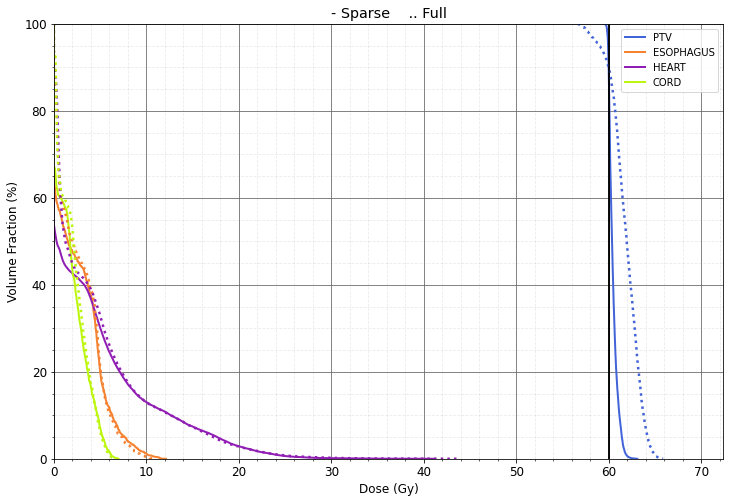

Done


In [14]:
# create plan_full object by specifying load_inf_matrix_full=True
beams_full = pp.Beams(data, load_inf_matrix_full=True)
# load influence matrix based upon beams and structure set
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
# use the full influence matrix to calculate the dose for the plan obtained by sparse matrix
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

# Visualize the DVH discrepancy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
# Turn on norm flag for same normalization for sparse and full dose.
ax = pp.Visualization.plot_dvh(plan_sparse, dose_1d=dose_sparse_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- Sparse    .. Full')
plt.show()
print('Done')


### 3) Manually sparsifying the full influence matrix

The sparse and full matrices are both pre-computed and included in the PortPy data. The sparse matrix was obtained by setting the small elements, i.e., those less than a certain threshold specified in 'my_plan.inf_matrix.sparse_tol', in the full matrix to zero. This threshold was calculated as 1% of the maximum value of the influence matrix for the planner's beams.

For demonstration purposes, we will manually generate the sparse matrix from the full matrix using the threshold specified by 'my_plan.inf_matrix.sparse_tol'. Note that users have the flexibility to sparsify the full matrix using any arbitrary threshold that suits their requirements.

In [15]:
#  Get A_sparse and A_full
A_full = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A

# Get the threshold value used by PortPy to truncate the matrix
# sparse_tol = 0.01*np.amax(A_full)
sparse_tol = plan_sparse.inf_matrix.sparse_tol


# Truncate the full matrix
A_full[A_full <= sparse_tol] = 0
test = np.abs(A_full - A_sparse.todense()) <= 1e-3

# Check if both influence matrices agree
assert test.all()